# Introduction

The purpose of this project is to analyze the results of governance proposals for SushiSwap and uncover any patterns amongst them that might be indicative of a success.

**Data Source**<br>
SushiSwap uses the Snapsot platform to manage governance proposal voting, so we can use the same platform to extract the data about all of the proposals.
- **SushiSwap Snapshot** - https://snapshot.org/#/sushigov.eth
- raw **proposal data** is in the `sushi_proposals.json` file
- the full **queries used** can be found in the `snapshotQuery_sushi.gql` file

## Setting up the environment
1. Import modules

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2. Set dataframe and graph options

In [107]:
pd.set_option('display.max_colwidth', 20)
sns.set_style('darkgrid')

# Data

## Loading the data
The raw data will be imported into a `Pandas Dataframe` so we can use Python to handle and analyze it.

- `id`(text): unique identifier for proposal
- `title`(text): the title of the proposal
- `choices`(list): contains all of the given voting options
- `start`(number): unix timestamp of starting date
- `end`(number): unix timestamp of ending date
- `snapshot`(number): block that locks the state of community members who are able to vote
- `author`(text): wallet address of the person who posted the proposal
- `votes`(number): total number of votes casted
- `scores`(list): contains the score for each available choice
- `scores_total`(number): total voting power aka 'SUSHIPOWAH'

In order to make the data more readable and interpretable, the `start` and `end` columns will be converted to ISO date and time formats.

In addition to these columns, we will insert two more:
- `num_choices`(number): count of options in the choices list
- `is_admin`(bool): whether the author of the proposal is currently an admin

In [108]:
df = pd.read_json('sushi_proposals.json')
df.start = pd.to_datetime(df.start, unit='s')
df.end = pd.to_datetime(df.end, unit='s')

admin = ['0x4bb4c1B0745ef7B4642fEECcd0740deC417ca0a0','0xb4A3f907ec1611F22543219AE9Bb33ec5E96e116','0x1C0Aa8cCD568d90d61659F060D1bFb1e6f855A20','0x285b7EEa81a5B66B62e7276a24c1e0F83F7409c1']
df['is_admin'] = df.author.isin(admin)
df['num_choices'] = df.choices.apply(lambda x: len(x))
df.head()

,id,title,choices,start,end,snapshot,author,votes,scores,scores_total,is_admin,num_choices
0,0x3e8c549e82d973...,Fund Team to Onb...,"[Yes, LFFFFGG, M...",2021-11-18 11:00:00,2021-11-21 11:00:00,13632357,0xBd31D988151DE3...,202,[106049.23305496...,1.080705e+05,False,3
1,0x8315ab4c4ef397...,Collateralize SU...,[Collateralize T...,2021-11-10 17:00:00,2021-11-15 17:00:00,13589329,0x1C0Aa8cCD568d9...,1027,[6728695.2336487...,6.746548e+06,True,3
2,QmcwEVRfidkg5U8n...,Community-Enable...,"[Fund CEA, Nay]",2021-10-19 16:00:00,2021-10-23 19:00:00,13450939,0x1C0Aa8cCD568d9...,804,[3361810.2412042...,3.559517e+06,True,2
3,QmNT8bY7aJRFUMtf...,Multichain Expan...,"[Yay, Nay]",2021-08-13 04:00:00,2021-08-17 19:00:00,13012538,0x285b7EEa81a5B6...,1108,[12358627.302780...,1.668710e+07,True,2
4,QmfEqngSUDtZHgQf...,oSUSHI [SIGNAL],[Start the gauge...,2021-08-13 04:00:00,2021-08-17 19:00:00,13012525,0x285b7EEa81a5B6...,1089,[14266737.701309...,1.432602e+07,True,2


## Data exploration
We can start off by checking the shape of the dataset. The **244 rows** each represent an observation of a single proposal posted by SushiSwap on their Snapshot page.

The earliest proposal was posted on 26 Aug 2020, and the most recent one was posted on 18 Nov 2021.

In [109]:
print('dataset shape:',df.shape)
print('first proposal:', df.start.min())
print('latest proposal:', df.start.max())

dataset shape: (244, 12)
first proposal: 2020-08-26 12:00:00
latest proposal: 2021-11-18 11:00:00


When we look at the rest of the variables, we see that there have been proposals with **0 votes**, but the most voted proposal gathered **1627 votes**, a huge engagement if we consider that the 4th quartile starts with just 66. The scores_total, given its close relationship to the number of votes casted, tells a simmilar story.

For the number of choices, it naturally starts at a minumum of 2, but it then goes up to 20 choices. That number is a clear outlier, as over 75% of all proposals only have 3 options or less.

In [110]:
df[['votes','scores_total','num_choices']].describe()

,votes,scores_total,num_choices
count,244.000000,2.440000e+02,244.000000
mean,116.979508,1.331518e+06,2.774590
std,267.932327,4.108310e+06,1.864331
min,0.000000,0.000000e+00,2.000000
25%,4.000000,4.303730e+02,2.000000
50%,18.000000,6.987941e+03,2.000000
75%,66.500000,1.007082e+05,3.000000
max,1627.000000,2.603272e+07,20.000000


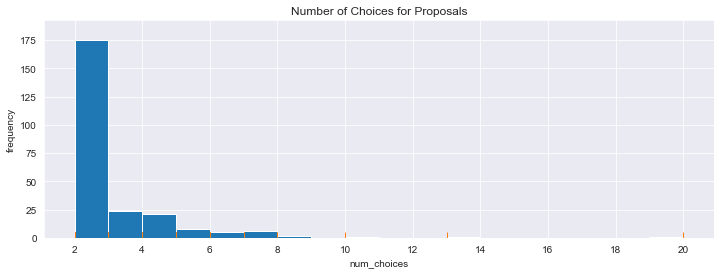

In [111]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot()
plt.hist(x=df.num_choices, bins=18)
ax1.set_xticks(range(2,21,2))
plt.title('Number of Choices for Proposals')
plt.ylabel('frequency')
sns.rugplot(data=df, x='num_choices')

plt.show()

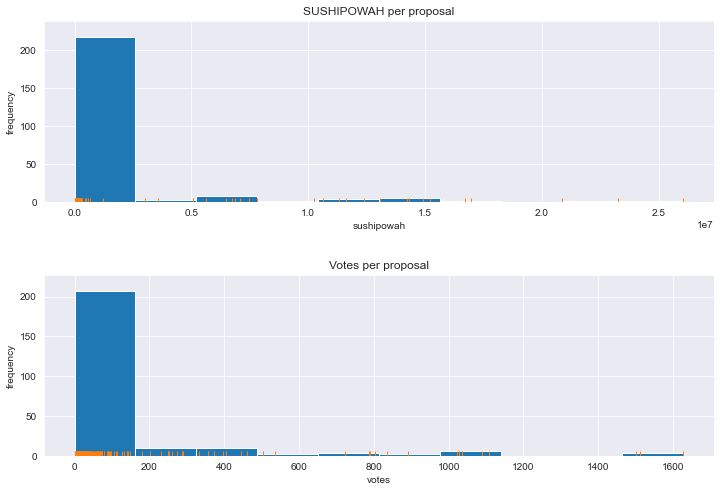

In [112]:
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,1,1)
plt.hist(x=df.scores_total)
plt.title('SUSHIPOWAH per proposal')
plt.xlabel('sushipowah')
plt.ylabel('frequency')
sns.rugplot(data=df, x='scores_total')

ax2 = plt.subplot(2,1,2)
plt.hist(x=df.votes)
plt.title('Votes per proposal')
plt.ylabel('frequency')
sns.rugplot(data=df, x='votes')

plt.subplots_adjust(hspace=0.4)
plt.show()

It is also worth checking the overall volume of proposals through time, and we can see that right after the launch time, in September 2020, there were a lot of published proposals which is to be expected for a project just starting off. 

Shortly after we can see the number of monthly proposals falling under 20, and it remained at a similar volume to this day.

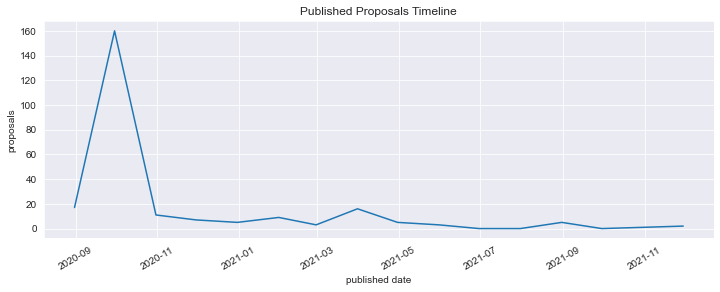

In [113]:
monthly_proposals = df.groupby(pd.Grouper(key='start', freq='M'))\
    .id.count()\
    .reset_index()
monthly_proposals.columns = ['publish_m','proposals']

plt.figure(figsize=(12,4))
ax = plt.subplot()
sns.lineplot(data=monthly_proposals, x='publish_m', y='proposals')
plt.title('Published Proposals Timeline')
plt.xlabel('published date')
plt.xticks(rotation=30)
plt.show()

# Patterns of a successful result
### Admin posts
We can see in the table below that there have been 124 authors, with only two of them being admins. One of the admins leads by the number of posted proposals, with 61, followed on the second spot with 16 proposals. In fact, the large majority of authors only have 2 proposals or less.

In [114]:
authors = df.groupby('author').agg({'scores_total':['sum','mean'],'votes':['sum','mean'], 'id':['count']}).reset_index()
authors.columns=['author','powah_sum','powah_mean','votes_sum','votes_mean','proposals']
authors.sort_values('proposals', ascending=False, inplace=True, ignore_index=True)
authors['is_admin'] = authors.author.isin(admin)
authors

,author,powah_sum,powah_mean,votes_sum,votes_mean,proposals,is_admin
0,0x285b7EEa81a5B6...,2.389125e+08,3.916599e+06,12652,207.409836,61,True
1,0x30a0911731f6eC...,3.904298e+07,2.440186e+06,1104,69.000000,16,False
2,0xE80B5097862cAB...,2.386428e+06,3.409183e+05,1925,275.000000,7,False
3,0xF942Dba4159CB6...,2.026889e+06,3.378149e+05,2462,410.333333,6,False
4,0x10747f32528d08...,2.588651e+01,6.471626e+00,7,1.750000,4,False
...,...,...,...,...,...,...,...
119,0x7A9dbEAd85731D...,0.000000e+00,0.000000e+00,1,1.000000,1,False
120,0x79F2E52181cE6e...,9.027131e+03,9.027131e+03,3,3.000000,1,False
121,0x781562dA1647Ff...,0.000000e+00,0.000000e+00,0,0.000000,1,False
122,0x7813F757C33CF4...,1.075149e+03,1.075149e+03,16,16.000000,1,False


Even if the top poster is an admin, the majority of proposals were authored by non-admin members, having 181 proposals to date.

In [115]:
admins = authors.groupby('is_admin').proposals.sum()
admins

is_admin
False    181
True      63
Name: proposals, dtype: int64

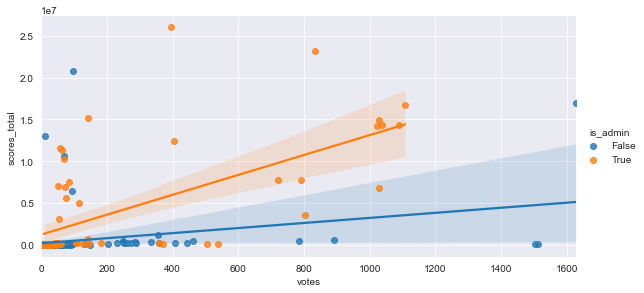

In [116]:
sns.lmplot(data=df, x='votes', y='scores_total', hue='is_admin', height=4, aspect=2)
plt.show()

We can see here that the number of votes and the overall score are loosely correlated, but it does turn out that on average, proposals authored by admins gather both a larger number of votes and more SUSHIPOWAH. This might be a result of admins having more exposure to the community, as well as generally being more engaged on various channels and having closer ties with large stakeholders of governance tokens.

Even so, we can see that on a few ocasions, non-admin members were able to rally huge support for a proposal, indicating that SushiSwap has an active and decentralized community.

### Number of choices
For this analysis we will ignore the outlier proposals with more than 6 choices as they are singular events and we can't draw conclusions about the voting tendencies based on only that.

In `fig.1` below we can see that proposals with 3 or 4 choices generally gather a number of votes above the average. Proposals with 2, 5, 6 or more choices, although at time able to rally an above average number of participans, generally they underperform. 

In `fig.2` we can see that only proposals with 3 choices stay over the line, with all others having a below average performance in regards to the SUSHIPOWER they were able to accumulate. The three options allow for polarised options, while keeping the way open for a compromise option or a middle way, and it seems to have worked out for the community.

However, having 3 options to choose from seems to be the sweet spot of successful proposals.

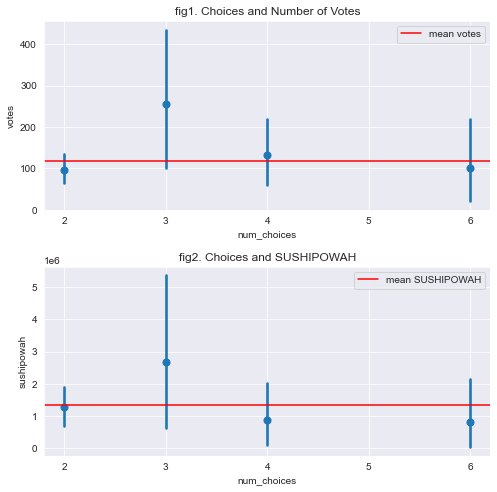

In [117]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(2,1,1)
sns.regplot(data=df, x='num_choices', y='votes', x_bins=18, fit_reg=False, ax=ax1)
plt.axhline(np.mean(df.votes), label='mean votes', color='r')
ax1.set_xticks(range(2,7))
plt.title('fig1. Choices and Number of Votes')
plt.legend()

ax2 = plt.subplot(2,1,2)
sns.regplot(data=df, x='num_choices', y='scores_total', x_bins=18, fit_reg=False, ax=ax2)
plt.axhline(np.mean(df.scores_total), label='mean SUSHIPOWAH', color='r')
ax2.set_xticks(range(2,7))
plt.title('fig2. Choices and SUSHIPOWAH')
plt.ylabel('sushipowah')
plt.legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

# Results

After this analysis we have determined two aspects that can lead to a more successful proposal:
1. Community engagement: We have come to this conclusion correlating the average number of votes and average SUSHIPOWAH gathered, and we could see that admin posts are outperforming other proposals. This is most likely a result of admins being more engaged and connected to the community and its needs, and thus formulating proposals and choices that members respond better to.
2. An optimum number of choices: And that sweet spot is 3. Having only 3 choices for a proposal can rally both more votes and of course, more SUSHIPOWAH!

## Further research
Further research is needed into particular proposal results, as well as how the voting went on in order to determine if there are crucial milestones while the voting is still open.

Another interesting aspect to be looked into is how members (1)prepare and (2)respond to these proposals, by either buying more governing tokens or selling them.